In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from multiprocessing import Pool
import time
import dill
from PIL import Image

In [5]:
def show_img(img):
    cv2.imshow("img", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
def show_plt_img(img_in):
    img = cv2.cvtColor(img_in, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
def print_max_min_median(M):
    print(f"max={M.max()}, min={M.min()}, median={np.median(M)}")
def show_with_mask(img, mask):
    coef_indxs = np.copy(mask)
    coef_indxs[coef_indxs == True] = 1
    coef_indxs[coef_indxs == False] = 0
    _3d_coef_indxs = np.repeat(coef_indxs[:, :, np.newaxis], 3, axis=2)
    plt.imshow(img * _3d_coef_indxs)

max=1.0, min=0.0, median=0.29411765933036804


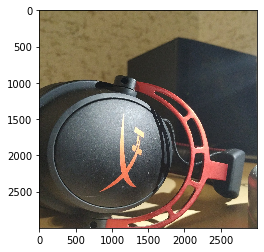

In [3]:
img = cv2.imread('input.jpg').astype('float32') / 255.0
print_max_min_median(img)
show_plt_img(img)

max=1.0, min=0.0, median=0.18039216101169586


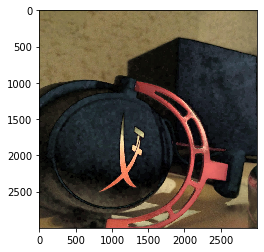

In [4]:
img_d = cv2.imread('I_d.jpg').astype('float32') / 255.0
print_max_min_median(img_d)
show_plt_img(img_d)

In [48]:
alpha = 0.1
theta = 0.01
sigma = 0.01

max=1.0, min=0.0, median=0.25882354378700256


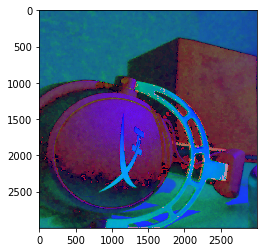

In [7]:
hsv_img = cv2.cvtColor(cv2.imread('input.jpg'), cv2.COLOR_BGR2HSV).astype('float32') / 255.0
print_max_min_median(hsv_img)
H, S, V = hsv_img[:, :, 0], hsv_img[:, :, 1], hsv_img[:, :, 2]
plt.imshow(hsv_img)

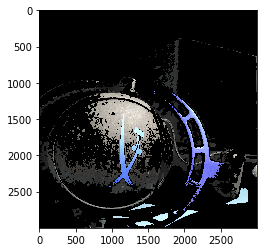

In [49]:
# alpha = 0.05
X_SV = np.array(S < alpha) | np.array(V > (1 - alpha))
show_with_mask(img, X_SV)

In [16]:
I_b, I_g, I_r = cv2.split(img)
I_gmd = np.minimum(I_b, I_g, I_r)
print_max_min_median(I_gmd)

max=1.0, min=0.0, median=0.26274511218070984


In [17]:
%%time
def check_bound(x, upper_bound):
    b1 = x - 1 > 0
    b2 = x + 1 < upper_bound
    return b1 and b2

G = np.copy(I_gmd)
for y in range(I_gmd.shape[0]):
    for x in range(I_gmd.shape[1]):
        if not check_bound(x, I_gmd.shape[1]) or  not check_bound(y, I_gmd.shape[0]):
            continue
        
        G[y, x] = np.sqrt( ( I_gmd[y, x+1] - I_gmd[y, x-1] ) ** 2  +  ( I_gmd[y+1, x] - I_gmd[y-1, x] ) ** 2 ) / 2

Wall time: 1min 5s


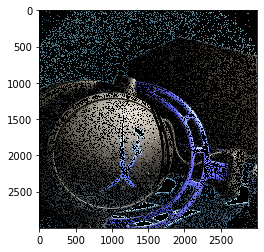

In [50]:
# theta = 0.02
X_G = np.array(G >= theta)
show_with_mask(img, X_G)

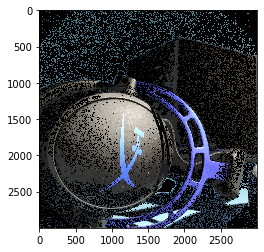

In [51]:
X_SVG = X_SV | X_G
show_with_mask(img, X_SVG)

Wall time: 646 ms


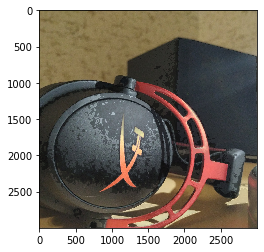

In [59]:
%%time
def calc_R_alpha_channel(alpha, I, I_max, alpha_channel):
    R = np.copy(I_max)
    R[alpha_channel] = alpha * I[alpha_channel] + (1 - alpha) * I_max[alpha_channel]
    return R

R2 = calc_R_alpha_channel(0.5, img_d, img, X_SV)


# f, ax = plt.subplots(1,1, figsize=(10,10))
# ax.imshow(R2.astype('uint8'))
show_plt_img(R2)

In [54]:
kernel = np.ones((5,5),np.float32)/25

for i in range(10):
    R2 = calc_R_alpha_channel(0.1 * i, img_d, img, X_SVG)
    dst = cv2.filter2D(R2, -1, kernel)
    cv2.imwrite(f"{i}.png", R2 * 255)  
    cv2.imwrite(f"{i}_mean.png", dst * 255)  

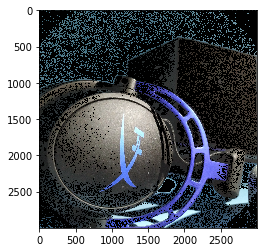

In [57]:
kernel = np.ones((5,5),np.float32)
mask = np.ones(X_SVG.shape)
mask[~X_SVG] = 0
dst = cv2.filter2D(mask, -1, kernel)
X_SVG[dst > 10] = True
show_with_mask(img, X_SVG)

In [58]:
kernel = np.ones((5,5),np.float32)/25

for i in range(10):
    R2 = calc_R_alpha_channel(0.1 * i, img_d, img, X_SVG)
    dst = cv2.filter2D(R2, -1, kernel)
    cv2.imwrite(f"{i}.png", R2 * 255)  
    cv2.imwrite(f"{i}_mean.png", dst * 255)  